# Runmila AI Institute & minoHealth AI Labs Tuberculosis Classification via X-Rays Challenge

File name: TuberculAI.ipynb

Author: kogni7

Date: September / October / November 2020

## Contents
* 1 Preparation
    * 1.1 Libraries and Seed
    * 1.2 Variables
* 2 Data
    * 2.1 Load CSV data
    * 2.2 Show some raw images
    * 2.3 Load images
    * 2.4 Show some augmented images
* 3 Model
* 4 Train Algorithm
* 5 Submission
    * 5.1 Training
    * 5.2 Prediction
    * 5.3 Saving

This notebook uses some basic ideas from this starter notebook:

https://github.com/leotafadzwa/Runmila-AI-Institute-Tuberculosis-Classification-baseline/blob/master/Runmila%20AI%20Chellenge%20Baseline%20.ipynb 

This notebook uses only the small data sets provided by ZINDI. These data sets contain X-Ray images of the upper body especially the lungs which are healthy or Tuberculosis positive. These images are the only used features in this notebook.

The file system for this project is:

- TuberculAI (root)
  - TuberculAI.ipynb (this notebook)
  - Data
      - train_small (images for training)
      - test_small (images for test)
      - Train.csv
      - Test.csv
      - SampleSubmission.csv
  - Submission
      - 1 - x: Submission directories, named by the version number
          - checkpoint_model.h5 (saved keras model)
          - model.h5 (saved keras model)
          - submission.csv

This jupyter notebook runs in Google Colab without special configuration. GPU and TPU are disabled. Enabling would accelerate processing, but the results are probably no more reproducible.

The idea of the notebook is a transfer learning based approach.


## 1. Preparation
### 1.1 Libraries and Seed

In [1]:
SEED = 42

# Math
import numpy as np

# Tensorflow
import tensorflow as tf

# Seeds
import random
import os
os.environ['PYTHONHASHSEED'] = str(SEED)

np.random.seed(SEED + 1)
random.seed(SEED + 2)

tf.random.set_seed(SEED + 3)

# Further imports
import time
from collections import namedtuple

# Working with CSV
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# OpenCV
import cv2

# Machine learning
from sklearn.metrics import auc, roc_curve

# Deep learning
from keras.models import Model
from keras.layers import BatchNormalization, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.constraints import max_norm

from keras.preprocessing.image import ImageDataGenerator

# The pretrained base models
from keras.applications import Xception, ResNet50V2, InceptionV3, DenseNet201

### 1.2 Variables

In [2]:
# The Version
VERSION = 13

# for use in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Working Directory
WD = os.getcwd() + "/drive/My Drive/Colab Notebooks/TuberculAI"
print(WD)

# Paths
train_path = WD + '/Data/train_small/'
test_path = WD + '/Data/test_small/'

# Base model (one of Xception, ResNet50V2, InceptionV3, DenseNet201)
BASE_MODEL = Xception

if BASE_MODEL == Xception:
    from keras.applications.xception import preprocess_input
elif BASE_MODEL == ResNet50V2:
    from keras.applications.resnet_v2 import preprocess_input
elif BASE_MODEL == InceptionV3:
    from keras.applications.inception_v3 import preprocess_input
elif BASE_MODEL == DenseNet201:
    from keras.applications.densenet import preprocess_input

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/TuberculAI


## 2 Data
### 2.1 Load CSV data

In [3]:
train_csv = pd.read_csv(WD + "/Data/Train.csv")
test_csv = pd.read_csv(WD + "/Data/Test.csv")
sample_submission = pd.read_csv(WD + "/Data/SampleSubmission.csv")

In [4]:
train_csv.head()

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,1
1,train/GVVXXDOZ.png,GVVXXDOZ,0
2,train/PMRSQLXN.png,PMRSQLXN,0
3,train/JXISWDUU.png,JXISWDUU,1
4,train/JVWMAACC.png,JVWMAACC,1


In [5]:
test_csv.head()

,filename,ID
0,test/GTWSHFYQ.png,GTWSHFYQ
1,test/QTFSSMGD.png,QTFSSMGD
2,test/TBLBHSYT.png,TBLBHSYT
3,test/ZKETEOFG.png,ZKETEOFG
4,test/GKTPBGZP.png,GKTPBGZP


In [6]:
sample_submission.head()

,ID,LABEL
0,GTWSHFYQ,0
1,QTFSSMGD,0
2,TBLBHSYT,0
3,ZKETEOFG,0
4,GKTPBGZP,0


Make new dataframes for later use.

In [7]:
train = pd.DataFrame({'ID': train_csv['ID'], 'LABEL': train_csv.LABEL.values,
                      'filepath': train_path + train_csv.ID.values + '.png'})
train['LABEL'] = train.LABEL.apply(lambda x: 'Positive' if x == 1 else 'Normal')

test = pd.DataFrame({'ID': test_csv['ID'], 'filepath': test_path + test_csv.ID.values + '.png'})

In [8]:
train.head()

,ID,LABEL,filepath
0,VTYNBFTO,Positive,/content/drive/My Drive/Colab Notebooks/Tuberc...
1,GVVXXDOZ,Normal,/content/drive/My Drive/Colab Notebooks/Tuberc...
2,PMRSQLXN,Normal,/content/drive/My Drive/Colab Notebooks/Tuberc...
3,JXISWDUU,Positive,/content/drive/My Drive/Colab Notebooks/Tuberc...
4,JVWMAACC,Positive,/content/drive/My Drive/Colab Notebooks/Tuberc...


In [9]:
test.head()

,ID,filepath
0,GTWSHFYQ,/content/drive/My Drive/Colab Notebooks/Tuberc...
1,QTFSSMGD,/content/drive/My Drive/Colab Notebooks/Tuberc...
2,TBLBHSYT,/content/drive/My Drive/Colab Notebooks/Tuberc...
3,ZKETEOFG,/content/drive/My Drive/Colab Notebooks/Tuberc...
4,GKTPBGZP,/content/drive/My Drive/Colab Notebooks/Tuberc...


### 2.2 Show some raw images

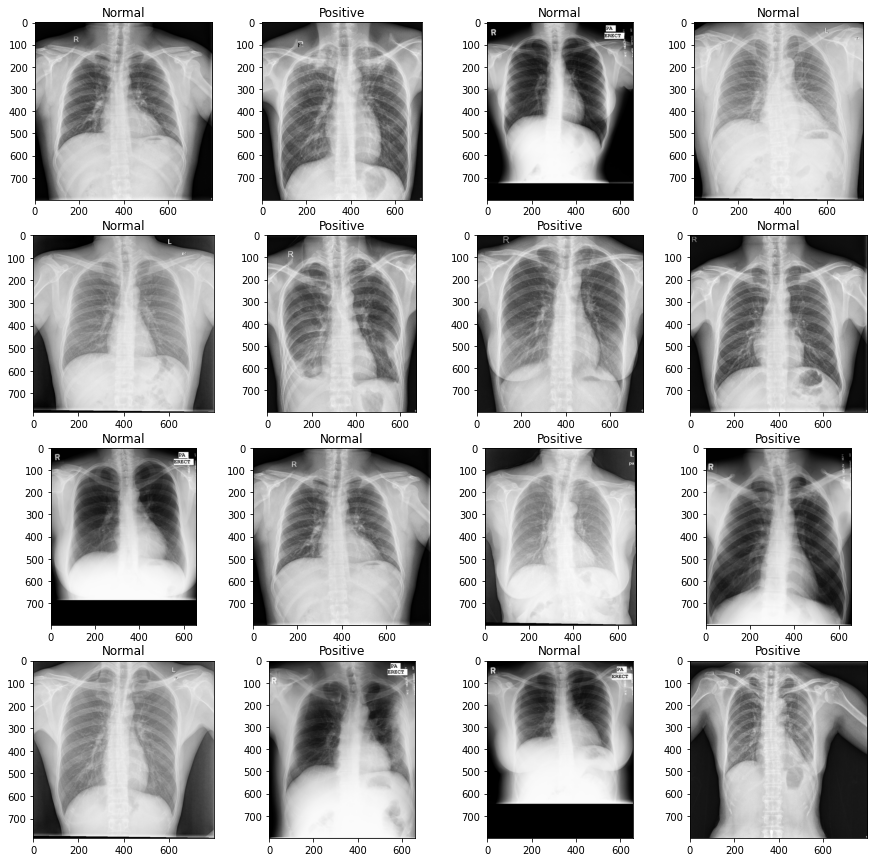

In [10]:
numbers = np.random.randint(len(train), size=16)

fig = plt.figure(figsize=(15, 15))

for i in range(16):
    image = cv2.imread(train.loc[numbers[i], 'filepath'])
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(train.loc[numbers[i], 'LABEL'])

plt.show()

### 2.3 Load images

In [11]:
def load_images(data, mode, preprocess, batch_size):
    """
    This function loads the images with keras instruments.
    """
    CLASSES = train.LABEL.unique().tolist()

    if mode == "TRAIN":
        generator = ImageDataGenerator(preprocessing_function=preprocess,
                                       width_shift_range=0.15,
                                       height_shift_range=0.2,
                                       zoom_range=0.1,
                                       horizontal_flip=True)

        return generator.flow_from_dataframe(data,
                                             x_col='filepath',
                                             y_col='LABEL',
                                             target_size=IMAGE_SIZE,
                                             classes=CLASSES,
                                             batch_size=batch_size,
                                             class_mode='binary',
                                             shuffle=True,
                                             seed=SEED)

    if mode == "VALIDATION":
        generator = ImageDataGenerator(preprocessing_function=preprocess)
    
        return generator.flow_from_dataframe(data,
                                             x_col='filepath',
                                             y_col='LABEL',
                                             target_size=IMAGE_SIZE,
                                             classes=CLASSES,
                                             batch_size=batch_size,
                                             class_mode='binary',
                                             shuffle=False)

    if mode == "TEST":
        generator = ImageDataGenerator(preprocessing_function=preprocess)

        return generator.flow_from_dataframe(data,
                                             x_col='filepath',
                                             target_size=IMAGE_SIZE,
                                             class_mode=None,
                                             batch_size=batch_size,
                                             shuffle=False)

### 2.4 Show some augmented images

Found 718 validated image filenames belonging to 2 classes.


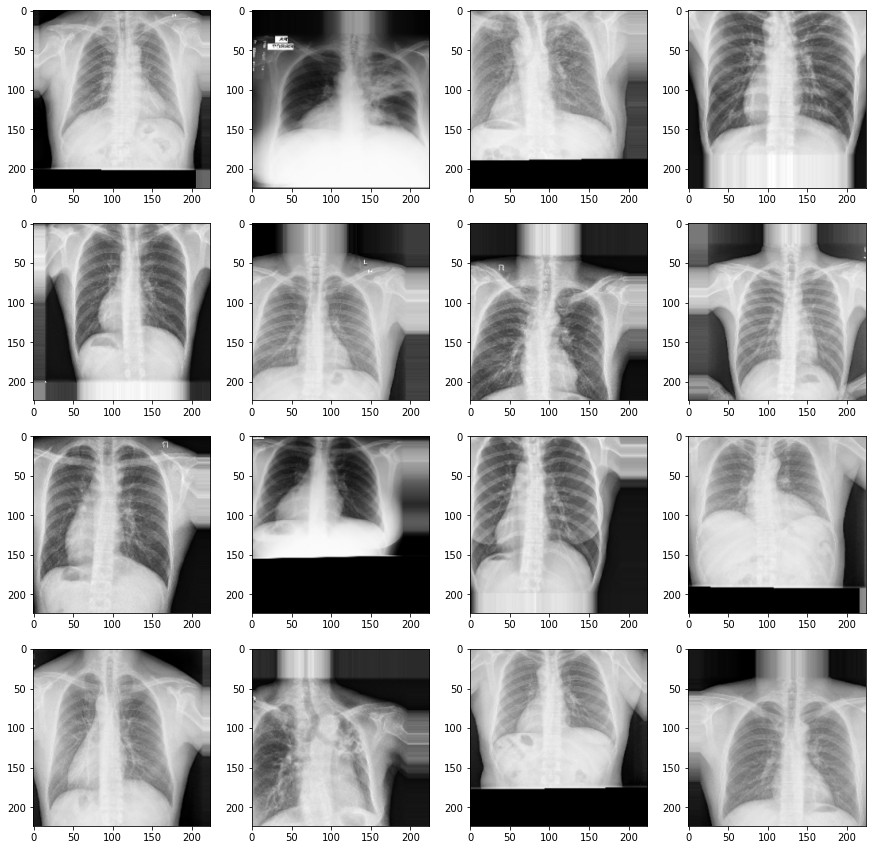

In [12]:
images = load_images(train, "TRAIN", None, 1)

fig = plt.figure(figsize=(15, 15))

for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    next_image = images.next()
    image = next_image[0].astype('uint8')
    plt.imshow(image[0, :, :, :], cmap=plt.get_cmap('gray'))
plt.show()

## 3 Model

In [13]:
def get_model(parameters):
    """
    The model using transfer learning.
    """
    # CONVOLUTIONAL NEURAL NETWORK
    base_model = parameters["Model"](include_top=False, weights='imagenet', 
                                     input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                     pooling=parameters["Pooling"])

    for layer in base_model.layers: layer.trainable = parameters["trainable"]

    layer = base_model.output

    layer = Dropout(parameters["base_model_dropout"], seed=SEED, name="Dropout_Base_Model")(layer)

    if parameters["BatchNormalization"]: layer = BatchNormalization()(layer)

    # PERCEPTRON
    for p in range(len(parameters["perceptron"])):
        layer = Dense(parameters["perceptron"][p], activation='relu',
                      kernel_constraint=parameters["perceptron_constraint"],
                      bias_constraint=parameters["perceptron_constraint"],
                      name="Perceptron_" + str(p + 1))(layer)

        layer = Dropout(parameters["perceptron_dropout"][p], seed=SEED, name="Dropout_" + str(p + 1))(layer)

        if parameters["BatchNormalization"]: layer = BatchNormalization()(layer)

    output = Dense(1, activation='sigmoid', name="Output")(layer)

    model = Model(inputs=base_model.input, outputs=output)

    # Model run
    model.compile(loss='binary_crossentropy', metrics=['AUC'], optimizer=Adam(lr=parameters['lr']))

    return model

## 4 Train Algorithm

In [14]:
def training(data, parameters):
    """
    This function is the training, i.e. 80% of data for training and 20% for validation.
    """

    print("Training is starting...")

    # Load data
    print("\nData loading...")
    fraction = int(0.8 * len(data))
    
    train_images = load_images(data[:fraction], "TRAIN", preprocess_input, BATCH_SIZE)
    validation_images = load_images(data[fraction:], "VALIDATION", preprocess_input, BATCH_SIZE)

    # Model
    print("\nModel building...")
    model = get_model(parameters)
    #model.summary()

    # Callbacks
    callbacks = []

    # Modelcheckpoint
    modelcheckpoint = ModelCheckpoint(filepath=WD + '/Submission/' + str(VERSION) + '/checkpoint_model.h5',
                                      save_weights_only=True, monitor='val_auc', mode='max', save_best_only=True)
    callbacks.append(modelcheckpoint)

    # Early Stopping
    if parameters["earlystopping"]:
        earlystopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
        callbacks.append(earlystopping)

    # Fit
    print("\nFitting...")
    model_fit=model.fit(train_images,
                        steps_per_epoch=np.ceil(fraction/BATCH_SIZE),
                        epochs=parameters["epochs"],
                        verbose=1,
                        validation_data=validation_images,
                        callbacks=callbacks)

    model.load_weights(WD + '/Submission/' + str(VERSION) + '/checkpoint_model.h5')

    # Calculate ROC
    print("\nCalculating ROC...")
    y_pred = model.predict(validation_images)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(validation_images.classes, y_pred.ravel())
    AUC = auc(false_positive_rate, true_positive_rate)
    print("AUC (validation): {:.2f}".format(AUC))

    # Plots
    print("\nPlotting...")
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].set_title("Learning", fontsize=20)
    axs[0].plot(model_fit.history['loss'], label='loss')
    axs[0].plot(model_fit.history['val_loss'], label='validation_loss')
    axs[0].legend()
    axs[0].set(xlabel='epoch', ylabel='loss')

    axs[1].set_title("AUC", fontsize=20)
    axs[1].plot(model_fit.history['auc'], label='auc')
    axs[1].plot(model_fit.history['val_auc'], label='validation_auc')
    axs[1].legend()
    axs[1].set(xlabel='epoch', ylabel='auc')

    axs[2].set_title("ROC curve (validation)", fontsize=20)
    axs[2].plot([0, 1], [0, 1], 'k--')
    axs[2].plot(false_positive_rate, true_positive_rate,
                label='AUC (validation) = {:.2f}'.format(AUC))
    axs[2].legend()
    axs[2].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    plt.show()

    return model

## 5 Submission
### 5.1 Training

Training is starting...

Data loading...
Found 574 validated image filenames belonging to 2 classes.
Found 144 validated image filenames belonging to 2 classes.

Model building...
83689472/83683744 [==============================] - 1s 0us/step

Fitting...
Epoch 1/100
18/18 [==============================] - 551s 31s/step - loss: 0.6930 - auc: 0.7238 - val_loss: 0.6869 - val_auc: 0.6497
Epoch 2/100
18/18 [==============================] - 512s 28s/step - loss: 0.6307 - auc: 0.7879 - val_loss: 0.7045 - val_auc: 0.5648
Epoch 3/100
18/18 [==============================] - 530s 29s/step - loss: 0.5901 - auc: 0.8002 - val_loss: 0.6940 - val_auc: 0.6240
Epoch 4/100
18/18 [==============================] - 506s 28s/step - loss: 0.4762 - auc: 0.8690 - val_loss: 0.6898 - val_auc: 0.8323
Epoch 5/100
18/18 [==============================] - 484s 27s/step - loss: 0.3902 - auc: 0.9097 - val_loss: 0.4665 - val_auc: 0.8790
Epoch 6/100
18/18 [==============================] - 489s 27s/step - loss: 0.3

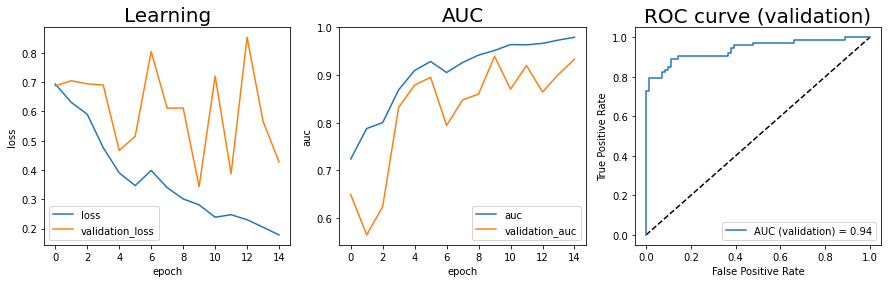

In [15]:
parameters = {}

# CNN
parameters["Model"] = BASE_MODEL
parameters["trainable"] = True
parameters["Pooling"] = 'avg'
parameters["base_model_dropout"] = 0.4

# PERCEPTRON
parameters["BatchNormalization"] = True
parameters["perceptron"] = [500, 500, 100]
parameters["perceptron_constraint"] = max_norm(1)
parameters["perceptron_dropout"] = [0.25, 0.25, 0.15]

parameters["lr"] = 0.001
parameters["epochs"] = 100

parameters["earlystopping"] = True

model = training(train, parameters)

### 5.2 Prediction

In [16]:
test_images = load_images(test, "TEST", preprocess_input, BATCH_SIZE)
prediction = model.predict(test_images)

Found 82 validated image filenames.


### 5.3 Saving

In [17]:
model.save(WD + '/Submission/' + str(VERSION) + '/model.h5')
output = pd.DataFrame({'ID': sample_submission.ID, 'LABEL': prediction[:, 0]})
output.to_csv(WD + '/Submission/' + str(VERSION) + '/submission.csv', index=False)
print("Done.")

Done.


In [18]:
drive.flush_and_unmount()